In [ ]:
#pip install tensorflow==1.14
#install for colab

In [187]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%matplotlib inline
#import dataset from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [188]:
# split data into train and test
x_train, y_train = mnist.train.images, mnist.train.labels
x_test, y_test = mnist.test.images, mnist.test.labels

#Reshape dataset for model
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [189]:
x_train.shape

(55000, 28, 28, 1)

In [190]:
#trainable finction for model layer freez and unfreez
def modifiy_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [191]:
#import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, Reshape, Input, Dropout,UpSampling2D,LeakyReLU
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
#from keras.layers.convolutional import UpSampling2D
#from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Model
from keras.backend import image_data_format

In [193]:
#Define generator learning rate
Gen_learningrate = 1e-4
#generator first input layer
gen_input = Input(shape= [100])
# Define generatore sequential model
generator = Sequential()
generator.add(Dense(200*14*14, kernel_initializer='glorot_normal'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
generator.add(Reshape([14,14,200]))
generator.add(UpSampling2D(size=(2,2)))
generator.add(Conv2D(100,(3,3), padding='same', kernel_initializer='glorot_uniform'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
generator.add(Conv2D(50,(3,3), padding='same', kernel_initializer='glorot_uniform'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
generator.add(Conv2D(1,(1,1), padding='same', kernel_initializer='glorot_uniform'))
generator.add(Activation('sigmoid'))


In [194]:
#combine input layer and other layer in one model
gen_model = Model(gen_input,generator(gen_input))

In [195]:
gen_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 28, 28, 1)         4341801   
Total params: 4,341,801
Trainable params: 4,263,101
Non-trainable params: 78,700
_________________________________________________________________


In [196]:
#compile generator
gen_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=Gen_learningrate))

In [197]:
#define discremenato learning rate
declearningrate = 1e-3
#discremenator input layer
dec_input=Input(shape=(28,28,1))

# define discremenatore sequential model
discriminator = Sequential()
discriminator.add(Conv2D(256,(5,5),strides=(2,2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512,(5,5),strides=(2,2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(2, activation='softmax'))

#combine input layer and other layers

des_model = Model(dec_input,discriminator(dec_input))
                  

In [198]:
des_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 2)                 9707266   
Total params: 9,707,266
Trainable params: 9,707,266
Non-trainable params: 0
_________________________________________________________________


In [199]:
# compile discremenator model
des_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=declearningrate))

In [200]:
#combine generator and discremenator in GAN
Generatorinput = Input(shape=[100])

Gan_op = gen_model(Generatorinput)
des_model.trainable = False
Discreminatoroutput = des_model(Gan_op)
GAN = Model(Generatorinput, Discreminatoroutput)
GAN.compile(loss='categorical_crossentropy', optimizer=Adam(lr=Gen_learningrate))
GAN.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
model_11 (Model)             (None, 28, 28, 1)         4341801   
_________________________________________________________________
model_12 (Model)             (None, 2)                 9707266   
Total params: 14,049,067
Trainable params: 4,263,101
Non-trainable params: 9,785,966
_________________________________________________________________


In [201]:
from IPython import display
import os

In [213]:

def plot_loss(losses, step):# loss plotting function
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(10,8))
    plt.plot(losses["d"], label="discriminative loss")
    plt.plot(losses["g"], label="generative loss")
    plt.legend()
    plt.savefig(os.path.join('generatedimages', 'loss_{}.png'.format(step)))
    plt.show()
    
    
def plot_gan(step, n_ex=16, dim=(4,4), figsize=(4,4)):# Generated image showing and saving function
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        img = generated_images[i, :, :, 0]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join('generatedimages', 'gann_{}.png'.format(step)))
    plt.show()


In [214]:
import random

In [215]:
# taking random samples
n_train = 1000
#train_idx = np.random.sample()
train_idx = random.sample(range(0, x_train.shape[0]), n_train)
print(type(train_idx))
print(len(train_idx))
print(train_idx[:10])

X_T = x_train[train_idx, :, :, :]
X_T.shape

<class 'list'>
1000
[20318, 33560, 53312, 1622, 25705, 3783, 51823, 32497, 15534, 12229]


(1000, 28, 28, 1)

In [216]:
# noise for generator
noise_gen = np.random.uniform(0,1,size=[X_T.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((X_T, generated_images))
X.shape

(2000, 28, 28, 1)

In [217]:
n = X_T.shape[0]
y = np.zeros([2*n,2])
y[:n, 1] = 1
y[n:, 0] = 1
print(y.shape)
print(y)

(2000, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [218]:
#cheking loss for noise
modifiy_trainable(des_model, True)
print(X.shape)
print(y.shape)
des_model.fit(X,y, epochs=1, batch_size=128)
y_pred = des_model.predict(X)

(2000, 28, 28, 1)
(2000, 2)
2000/2000 [==============================] - ETA: 9s - loss: 0.115 - ETA: 9s - loss: 0.111 - ETA: 8s - loss: 0.157 - ETA: 7s - loss: 0.138 - ETA: 7s - loss: 0.146 - ETA: 6s - loss: 0.134 - ETA: 5s - loss: 0.125 - ETA: 5s - loss: 0.113 - ETA: 4s - loss: 0.105 - ETA: 3s - loss: 0.099 - ETA: 3s - loss: 0.095 - ETA: 2s - loss: 0.089 - ETA: 1s - loss: 0.087 - ETA: 1s - loss: 0.086 - ETA: 0s - loss: 0.083 - 11s 5ms/sample - loss: 0.0813


In [219]:
print(y_pred.shape)
y_pred_idx = np.argmax(y_pred, axis=1)
print(y_pred_idx.shape)
print(y.shape)
y_idx = np.argmax(y, axis =1)
print("y_idx[10:] :", y_idx[10:])
print("y_idx[1500:] :", y_idx[1500:])
diff = y_idx - y_pred_idx
print(diff.shape)
print(diff[:10])
n_total = y.shape[0]
n_rig = (diff==0).sum()
acc = float(n_rig*100.0/n_total)

print("Accuracy : {} of {} right".format(acc, n_rig, n_total))

(2000, 2)
(2000,)
(2000, 2)
y_idx[10:] : [1 1 1 ... 0 0 0]
y_idx[1500:] : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0

In [220]:
# intialize noise
losses = {"d":[], "g":[]}

In [221]:
from tqdm import tqdm

In [222]:
#deine train function for model
def train_for_n(epoch=5000, plt_frq=25, batch_size=32):
    for e in tqdm(range(epoch)):
        
        image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
        noise_gen = np.random.uniform(0,1,size=[batch_size, 100])
        generated_images = gen_model.predict(noise_gen)
        
        #concat image batch and generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*batch_size,2])
        y[:batch_size,1] = 1
        y[batch_size:, 0] = 1
        #plot loss
        modifiy_trainable(des_model, True)
        d_loss = des_model.train_on_batch(X,y)
        losses["d"].append(d_loss)
        #training noise
        noise_tr = np.random.uniform(0,1,size=[batch_size,100])
        y2 = np.zeros([batch_size,2])
        y2[:,1] =1
        
        modifiy_trainable(des_model,False)
        g_loss = GAN.train_on_batch(noise_tr,y2)
        losses["g"].append(g_loss)
        
        if e%plt_frq == plt_frq -1:
            plot_loss(losses,e)
            plot_gan(e)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

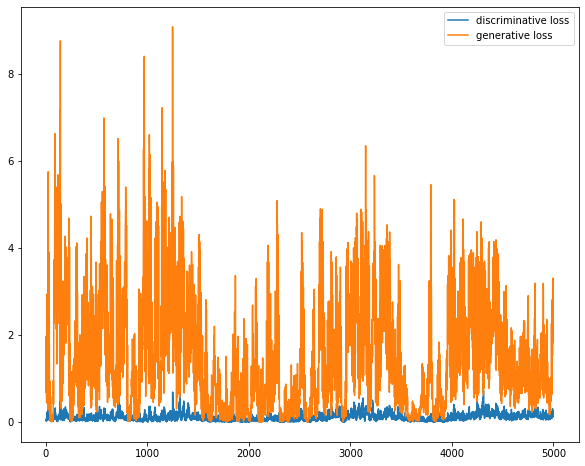

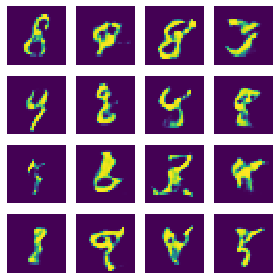





100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:52:48<00:00,  2.53s/it]

In [223]:
#call training function for 5000 epochs with 64 batch size
train_for_n(epoch=5000, plt_frq=25, batch_size=64)